<a href="https://colab.research.google.com/github/prakharsingh97/Musings_on_BERT/blob/main/bert_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Pre-Trained BERT



In [ ]:
!pip install transformers

     |████████████████████████████████| 1.8MB 5.5MB/s 
     |████████████████████████████████| 2.9MB 30.0MB/s 
     |████████████████████████████████| 890kB 43.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=55d5eec192fc8656a1f4aa07384e97e169bb52507f55eecf92b55a00b0b0f0b6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import torch
#torch used instead of tf cuz it is more easier to comprehened 
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary) . Trained upon Wikipedia and Book Corpus
#  BERT model has 2 parts  base and large 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

## Input Formatting


Because BERT is a pretrained model that expects input data in a specific format, we will need:


1.   A special token, [SEP], to mark the end of a sentence, or the separation   between two sentences
2.   A special token, [CLS], at the beginning of our text. This token is used for classification tasks, but BERT expects it no matter what your application is
3.   Tokens that conform with the fixed vocabulary used in BERT
4.   Mask IDs to indicate which elements in the sequence are tokens and which are padding elements
5.   Segment IDs used to distinguish different sentences
6.   Positional Embeddings used to show token position within the sequence

Luckily, the transformers interface takes care of all of the above requirements (using the t**okenizer.encode_plus function**).

For Example :
2 Sentence Input:


> [CLS] The man went to the store. [SEP] He bought a gallon of milk.


1 Sentence Input:
> [CLS] The man went to the store. [SEP]

# Tokenization

In [ ]:
text = "Here is the sentence I want embeddings for."
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens
print (tokenized_text)

['[CLS]', 'here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.', '[SEP]']


> ['em', '##bed', '##ding', '##s']


1.   The original word has been split into smaller subwords and characters.
2.   The two hash signs preceding some of these subwords are just our tokenizer’s way to denote that this subword or character is part of a larger word and preceded by another subword. 
> the ‘**##bed’** token is separate from the ‘bed’ token; the first is used whenever the subword ‘bed’ occurs within a larger word and the second is used explicitly for when the standalone token **‘thing you sleep on’** occurs.

## Why does it look this way? 
>This is because the BERT tokenizer was created with a **WordPiece model.** 
>WordPiece model generated a vocabulary that contains all English characters plus the ~30,000 most common words and subwords found in the English language corpus the model is trained on. 

## How does it tokenize ?
 >  1.  The tokenizer first checks if the whole word is in the vocabulary. 
 >  2.  If not, it tries to break the word into the largest possible subwords contained in the vocabulary, 
 >  3.  As a last resort will decompose the word into individual characters. 



In [ ]:
list(tokenizer.vocab.keys())[5000:5020]

['knight',
 'lap',
 'survey',
 'ma',
 '##ow',
 'noise',
 'billy',
 '##ium',
 'shooting',
 'guide',
 'bedroom',
 'priest',
 'resistance',
 'motor',
 'homes',
 'sounded',
 'giant',
 '##mer',
 '150',
 'scenes']

After breaking the text into tokens, we then have to convert the sentence from a list of strings to a list of vocabulary indeces.



In [ ]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


## Segment ID
BERT is trained on and expects sentence pairs, using 1s and 0s to distinguish between the two sentences. That is, for each token in “tokenized_text,” we must specify which sentence it belongs to: sentence 0 (a series of 0s) or sentence 1 (a series of 1s). For our purposes, single-sentence inputs only require a series of 1s, so we will create a vector of 1s for each token in our input sentence.

In [ ]:
# Mark each of the 22 tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


#Running BERT on our text

We need to convert our data to torch tensors and call the BERT model. 

The BERT PyTorch interface requires that the data be in **torch tensors **rather than Python lists.

>This does not change the shape or the data.


In [ ]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])
print(tokens_tensor)

tensor([[  101,  2044, 11065,  2769,  2013,  1996,  2924, 11632,  1010,  1996,
          2924, 27307,  2001,  2464,  5645,  2006,  1996,  5900,  2314,  2924,
          1012,   102]])


Calling 

``from_pretrained``


 will fetch the model from the internet.

``model.eval()``

Puts our model in evaluation mode as opposed to training mode. 
In this case, evaluation mode turns off dropout regularization which is used in training.

In [ ]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

# Understanding the Output

The full set of hidden states for this model, stored in the object ``hidden_states``, is a little dizzying.

This object has four dimensions, in the following order:

<ol type = "i">
<li> The layer number (13 layers)</li>
<li> The batch number (1 sentence)</li>
<li> The word / token number (22 tokens in our sentence) </li>
<li> The hidden unit / feature number (768 features) </li>

#### Wait, 13 layers? 

###### Doesn’t BERT only have 12? 
>It’s 13 because the first element is the input embeddings, the rest is the outputs of each of BERT’s 12 layers.

#### ``That’s 219,648 unique values just to represent our one sentence!``

In [ ]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


Let’s take a quick look at the range of values for a given layer and token.

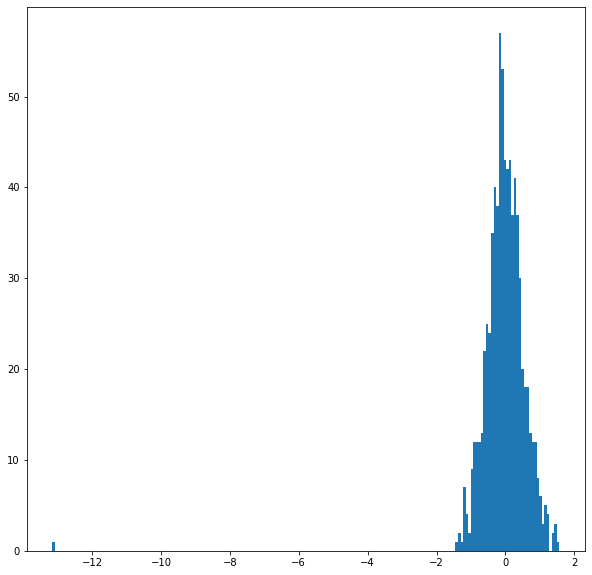

In [ ]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

Grouping the values by layer makes sense for the model, but for our purposes we want it grouped by token.

Current Dimensions

``[# layers, # batches, # tokens, # features]``

Desired Dimensions 

``[# tokens, # layers, # features]``


Luckily, PyTorch includes the ``permute`` function for easily rearranging the dimensions of a tensor.

In [ ]:
# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 22, 768])


In [ ]:
#Let’s combine the layers to make this one whole big tensor.
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 22, 768])

In [ ]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 22, 768])

In [ ]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([22, 13, 768])

#  Creating word and sentence vectors from hidden states

Now, what do we do with these hidden states? We would like to get individual vectors for each of our tokens, or perhaps a single vector representation of the whole sentence, but for each token of our input we have 13 separate vectors each of length 768.

## Word Vectors

To give you some examples, let’s create word vectors two ways.

First, let’s concatenate the last four layers, giving us a single word vector per token. Each vector will have length ``4 x 768 = 3,072``.

In [ ]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 22 x 3072


As an alternative method, let’s try creating the word vectors by ``summing`` together the last four layers.

In [ ]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 22 x 768


##Sentence Vectors

To get a single vector for our entire sentence we have multiple application-dependent strategies, but a simple approach is to average the second to last hiden layer of each token producing a single 768 length vector.

In [ ]:
# `hidden_states` has shape [13 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

In [ ]:
print ("Our final sentence embedding vector of shape:", sentence_embedding.size())

Our final sentence embedding vector of shape: torch.Size([768])


# Confirming contextually dependent vectors

To confirm that the value of these vectors are in fact contextually dependent, let’s look at the different instances of the word “bank” in our example sentence:

``“After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank.”``

Let’s find the index of those three instances of the word “bank” in the example sentence.

In [ ]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


They are at ``6, 10, and 19``.

For this analysis, we’ll use the word vectors that we created by summing the last four layers.

We can try printing out their vectors to compare them.

In [ ]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs_sum[6][:5]))
print("bank robber  ", str(token_vecs_sum[10][:5]))
print("river bank   ", str(token_vecs_sum[19][:5]))

First 5 vector values for each instance of "bank".

bank vault    tensor([ 3.3596, -2.9805, -1.5421,  0.7065,  2.0031])
bank robber   tensor([ 2.7359, -2.5577, -1.3094,  0.6797,  1.6633])
river bank    tensor([ 1.5266, -0.8895, -0.5152, -0.9298,  2.8334])


We can see that the values differ, but let’s calculate the ``cosine similarity`` between the vectors to make a more precise compariso

In [ ]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[19])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.94
Vector similarity for *different* meanings:  0.69
